# What is cooking and what else should we put?

**Introduction**

We explore the potential of creating new recipes via text data. Our goal has two folds. First, we aim to classify the cuisine based on ingredients. Second, we want to recommend ingredients that can potentially go well with a given list of ingredients based on the similarity scores that we learned from the original data.

The first task can be formulated as a multi-class classification problem. The second task involves recommender systems and ranking. To convert the text into numerical signals, we can use bag-of-words model with TF-IDF vectorizer, Countvectorizer. We will also consider building word embeddings with word2vec embedding, or other pre-trained embedding layers for training neural networks. We compare several well-known classification algorithms such as logistic regression, naive bayes, discriminant analysis. The evaluation methods will include F1-score, recall and precision. 

This notebook mainly focuses on the first task. The second task will be recorded in another notebook for the sake of document organization. We have the following sections in this notebook:

* Exploratory Data Analysis
    * Distribution of cuisine types
    * Top 50 ingredients by frequency in data
    * Distribution of the number of ingredients
    * The number of cuisines that has over 30 ingredients
* Obtaining vectorial representation
    * Tfidf Vectorizer
    * Count Vectorizer
    * 39774 by 300 average weight matrix based on word2vec model
    * 39774 by 300 average weight matrix based on Normalized word2vec model 
* Comparing PCA and TSNE on different vectorial representations
* Dimensionality Reduction with PCA and K-Means mapping labels
* Preparing for training and testing set
* Model selection and comparison
    * Models Overview and Justification of Model Choice 
    * Evaluation Metrics
        * 5-fold cross validation with f1-micro score metric
    * Preliminary result
    * Fine-tuning with gridsearch cross-validation
    * F1-micro averaged score curve

In [1]:
# Load packages
import sys
import json
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, label_binarize
from keras.preprocessing.text import Tokenizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import itertools
import numpy as np
sys.path.append('../code/')
from painter import *
from text_preprocess import *
from model_examiner import *
import gc
seed = 208

Using TensorFlow backend.


Exploratory Data Analysis

**Observations:**

* This is an imbalanced dataset. Italian cuisine has the highest number of occurance in the dataset, whereas Brazilian has the least number of occurance.

* Salt, olive oil, onion, water, and garlic are the top 5 ingredients by occurance in the data

* Most cuisines have around 10 ingredients in the data.

* Most cuisines that have over 30 ingredients are Mexican and Indian food.

In [2]:
# Load data
f = open('../data/train.json','r', encoding = 'utf-8')
data = pd.read_json(f)
data

id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]

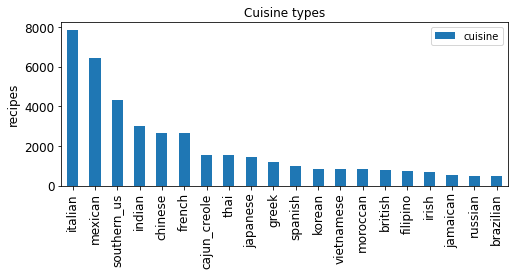

In [3]:
# Visualize the number of cuisines 
ax = data['cuisine'].value_counts().plot(kind='bar', title ="Cuisine types", figsize=(8, 3), legend=True, fontsize=12)
ax.set_ylabel("recipes", fontsize=12)
plt.show()

In [4]:
# Look at the top 50 ingredients
a = data['ingredients']
ax = list(itertools.chain.from_iterable(a))
listofingredients = Counter(ax)
# Convert Counter Object to dataframe
ingredientsCount = pd.DataFrame.from_dict(listofingredients, orient='index').reset_index()
# Change the column name
ingredientsCount.columns = ["ingredient", "count"]
# Get the top 50 rows after sorting
top50food = ingredientsCount.sort_values(by="count", ascending=False).head(50)

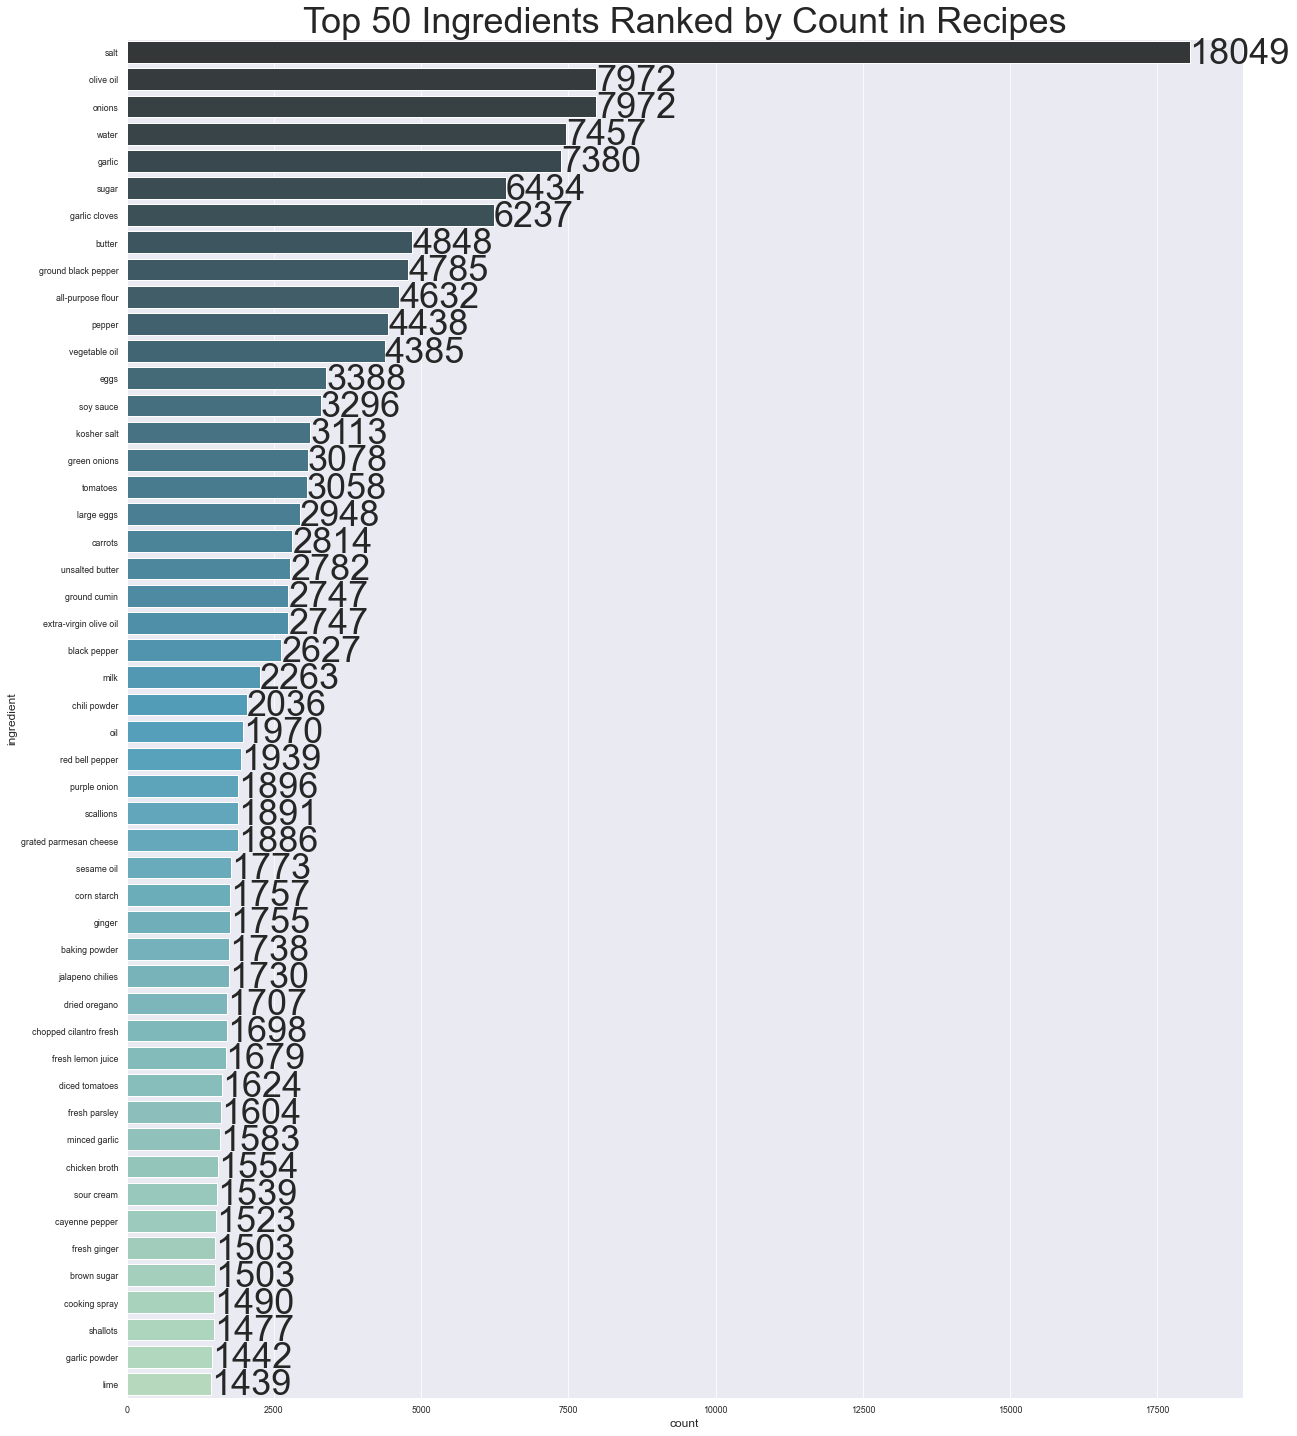

In [9]:
# Plot out the top 50 ingredients
plotBar(top50food, xlab="count", ylab="ingredient", title='Top 50 Ingredients Ranked by Count in Recipes', scale = True, show_font_on_har= True, font_scale = 3, col_palette = "GnBu_d")

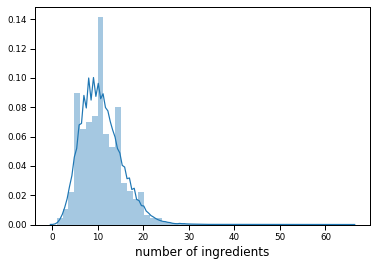

In [3]:
# Add the number of ingredients to the data
data["number of ingredients"] = data["ingredients"].apply(len)
# Plot the distribution of the number of ingredients
sns.set_context("paper", rc={"font.size":12,"axes.labelsize":12})# adjust the font size  
sns.distplot(data["number of ingredients"])# plot the graph

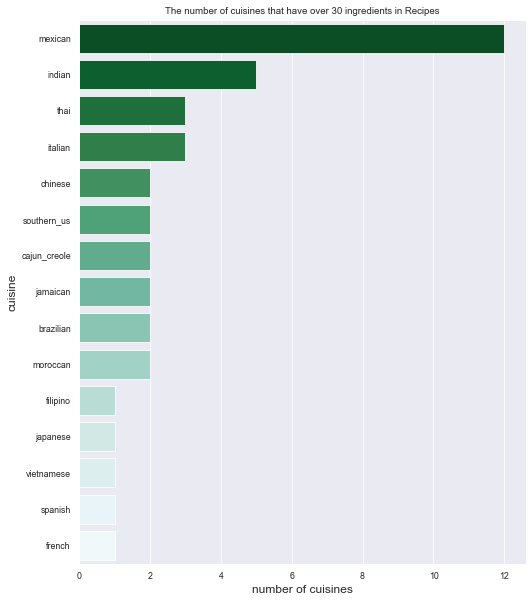

In [7]:
# Show all the cuisine that has more than 30 ingredients
over30ingredients = Counter(data[data["number of ingredients"]>30]["cuisine"])
over30ingredients = pd.DataFrame.from_dict(over30ingredients, orient='index').reset_index()
# Change the column name
over30ingredients.columns = ["cuisine", "number of cuisines"]
# Sort values from highest to lowest
over30ingredients = over30ingredients.sort_values(by="number of cuisines", ascending = False)
# Plot the bar chart
plotBar(over30ingredients, xlab= "number of cuisines", ylab= "cuisine", size =(8,10),title ='The number of cuisines that have over 30 ingredients in Recipes', )

**Preprocessing steps:**
1. Turning to lower case
2. remove all ( .oz) description
3. Lemmatizing the string
4. De-accent the string
5. Strip out everything else besides letter

In [10]:
# Clean the ingredient text data
corpus = text_preprocess(data)
# Flatten a list of lists for bag of words model
bow_corpus = [" ".join(doc) for doc in corpus]

**Apply the following find the vectorial representation**

* Tfidf vectorizer
* Count vectorizer
* Normalized Count vectorizer
* Word2vec model
* Normalized Word2vec model

**1. Tfidf vectorizer**

In [11]:
# convert text to word frequency vectors with TfidfVectorizer.
vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(bow_corpus)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf

abalone  abbamele  absinthe  abura  acai  accent  accompaniment  \
0          0.0       0.0       0.0    0.0   0.0     0.0            0.0   
1          0.0       0.0       0.0    0.0   0.0     0.0            0.0   
2          0.0       0.0       0.0    0.0   0.0     0.0            0.0   
3          0.0       0.0       0.0    0.0   0.0     0.0            0.0   
4          0.0       0.0       0.0    0.0   0.0     0.0            0.0   
...        ...       ...       ...    ...   ...     ...            ...   
39769      0.0       0.0       0.0    0.0   0.0     0.0            0.0   
39770      0.0       0.0       0.0    0.0   0.0     0.0            0.0   
39771      0.0       0.0       0.0    0.0   0.0     0.0            0.0   
39772      0.0       0.0       0.0    0.0   0.0     0.0            0.0   
39773      0.0       0.0       0.0    0.0   0.0     0.0            0.0   

       achiote  acid  acinus  ...  yuzu  yuzukosho  zaatar  zatarains  zero  \
0          0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
1          0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
2          0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
3          0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
4          0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
...        ...   ...     ...  ...   ...        ...     ...        ...   ...   
39769      0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
39770      0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
39771      0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
39772      0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   
39773      0.0   0.0     0.0  ...   0.0        0.0     0.0        0.0   0.0   

       zest     zesty  zinfandel  ziti  zucchini  
0       0.0  0.000000        0.0   0.0       0.0  
1       0.0  0.000000        0.0   0.0       0.0  
2       0.0  0.000000        0.0   0.0       0.0  
3       0.0  0.000000        0.0   0.0       0.0  
4       0.0  0.000000        0.0   0.0       0.0  
...     ...       ...        ...   ...       ...  
39769   0.0  0.000000        0.0   0.0       0.0  
39770   0.0  0.346432        0.0   0.0       0.0  
39771   0.0  0.000000        0.0   0.0       0.0  
39772   0.0  0.000000        0.0   0.0       0.0  
39773   0.0  0.000000        0.0   0.0       0.0  

[39774 rows x 2849 columns]

**2. Counter Vectorizer**

In [12]:
# convert text to word count vectors with CountVectorizer.
vec = CountVectorizer()
X = vec.fit_transform(bow_corpus)
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
dtm

abalone  abbamele  absinthe  abura  acai  accent  accompaniment  \
0            0         0         0      0     0       0              0   
1            0         0         0      0     0       0              0   
2            0         0         0      0     0       0              0   
3            0         0         0      0     0       0              0   
4            0         0         0      0     0       0              0   
...        ...       ...       ...    ...   ...     ...            ...   
39769        0         0         0      0     0       0              0   
39770        0         0         0      0     0       0              0   
39771        0         0         0      0     0       0              0   
39772        0         0         0      0     0       0              0   
39773        0         0         0      0     0       0              0   

       achiote  acid  acinus  ...  yuzu  yuzukosho  zaatar  zatarains  zero  \
0            0     0       0  ...     0          0       0          0     0   
1            0     0       0  ...     0          0       0          0     0   
2            0     0       0  ...     0          0       0          0     0   
3            0     0       0  ...     0          0       0          0     0   
4            0     0       0  ...     0          0       0          0     0   
...        ...   ...     ...  ...   ...        ...     ...        ...   ...   
39769        0     0       0  ...     0          0       0          0     0   
39770        0     0       0  ...     0          0       0          0     0   
39771        0     0       0  ...     0          0       0          0     0   
39772        0     0       0  ...     0          0       0          0     0   
39773        0     0       0  ...     0          0       0          0     0   

       zest  zesty  zinfandel  ziti  zucchini  
0         0      0          0     0         0  
1         0      0          0     0         0  
2         0      0          0     0         0  
3         0      0          0     0         0  
4         0      0          0     0         0  
...     ...    ...        ...   ...       ...  
39769     0      0          0     0         0  
39770     0      1          0     0         0  
39771     0      0          0     0         0  
39772     0      0          0     0         0  
39773     0      0          0     0         0  

[39774 rows x 2849 columns]

**3. Normalized Counter Vectorizer**

In [13]:
normalizer = Normalizer()
norm_dtm = normalizer.fit_transform(dtm)
norm_dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**4. Word2Vec model**

Here we utilize word2vec model and create a 39774 by 300 matrix by summing the list of ingredient vectors (each ingredient corresponds to a 300 dimensional vector) for each row and divide the resulting 300-dimensional vector by the number of ingredients in that list.

In [14]:
# Word2vec model parameters
# Word vector dimensionality       
num_features = 300    
# 50% of the corpus                                 
min_word_count = 1
# Number of CPUs   
num_workers = 4       
# Context window size; 
# let's use avg recipte size   
context = 10
# threshold for configuring which higher-frequency words are randomly downsampled                                                                                         
downsampling = 1e-3   

# Initialize and train the model 
word2vec = Word2Vec(corpus, workers=num_workers, \
                 size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling)

In [15]:
# Utilize the word embedding to build a similary matrix 
avg_word_mat = convertWord2VecForTrainTestSplit(word2vec, corpus)

**5. Normalized Word2Vec model**

In [16]:
# Precompute L2-normalized vectors
word2vec.init_sims(replace=True)
norm_avg_word_mat = convertWord2VecForTrainTestSplit(word2vec, corpus)

**PCA decomposition**

**Comments:**

* We see that sugar and sauce have the most loading respectively based on the largest absolute value. It means that sugar and sauce account most of the variance in the data when we reduce the dimensionality of the tfidf representation of the data.

In [17]:
# Run the PCA decomposition
pca = PCA(n_components=2)
# Implement PCA on the standardized data
result = pca.fit_transform(tfidf)
# Check the loadings
loadings = pd.DataFrame(pca.components_.T, columns= ['PC1', 'PC2'], index=tfidf.columns)
# Check which variable has the most loading in the first component
loadings.sort_values(by = "PC1", ascending= False)

PC1       PC2
sugar   0.251852  0.166063
egg     0.242093 -0.043559
flour   0.241893 -0.066192
baking  0.207116 -0.021205
butter  0.196971 -0.089673
...          ...       ...
onion  -0.166772  0.015138
garlic -0.173202  0.018968
tomato -0.175198 -0.138873
fresh  -0.182497 -0.070773
pepper -0.236899 -0.080515

[2849 rows x 2 columns]

In [18]:
# Check which variable has the most loading in the second component
loadings.sort_values(by = "PC2", ascending= False)

PC1       PC2
sauce    -0.086384  0.343885
soy      -0.035486  0.305706
sesame   -0.025570  0.259749
rice     -0.053031  0.192009
ginger   -0.054194  0.188717
...            ...       ...
grated    0.006654 -0.137237
tomato   -0.175198 -0.138873
parmesan -0.022474 -0.163357
olive    -0.158877 -0.195968
cheese   -0.020935 -0.333355

[2849 rows x 2 columns]

In [20]:
# Run the PCA decomposition
pca = PCA(n_components=2)
# Implement PCA on the standardized data
result = pca.fit_transform(dtm)
# Check the loadings
loadings = pd.DataFrame(pca.components_.T, columns= ['PC1', 'PC2'], index=tfidf.columns)
# Check which variable has the most loading in the first component
loadings.sort_values(by = "PC1", ascending= False)

PC1       PC2
pepper   0.515724 -0.121529
ground   0.329498 -0.394960
onion    0.260636  0.067091
garlic   0.250812  0.118588
fresh    0.226675  0.064787
...           ...       ...
vanilla -0.067136 -0.044780
flour   -0.081778 -0.135454
butter  -0.082893 -0.137990
egg     -0.107363 -0.107521
sugar   -0.161417  0.061573

[2849 rows x 2 columns]

In [21]:
# Check which variable has the most loading in the second component
loadings.sort_values(by = "PC2", ascending= False)

PC1       PC2
sauce   0.079489  0.472893
soy     0.017251  0.260409
oil     0.213657  0.239724
sesame  0.013472  0.191294
rice    0.041837  0.182631
...          ...       ...
flour  -0.081778 -0.135454
butter -0.082893 -0.137990
salt    0.128687 -0.183352
cheese  0.028445 -0.221428
ground  0.329498 -0.394960

[2849 rows x 2 columns]

**PCA vs. TSNE on Tfidf matrix representation**

* For the tfidf representation, we see that TSNE is more capable of separating different cusines. Interestingly, we can see that some cuisines tend to be together. For example, French, Indian, and Jamaican food always posit togther in both PCA and TSNE. From the PCA plot, we can see that the clusters of French, Indian, and Jamaican food strech on second principal component, whereas the clusters of Mexican and Italian food strech on first principal component. It indicates the underlying differences among the ingredients of these two groups.

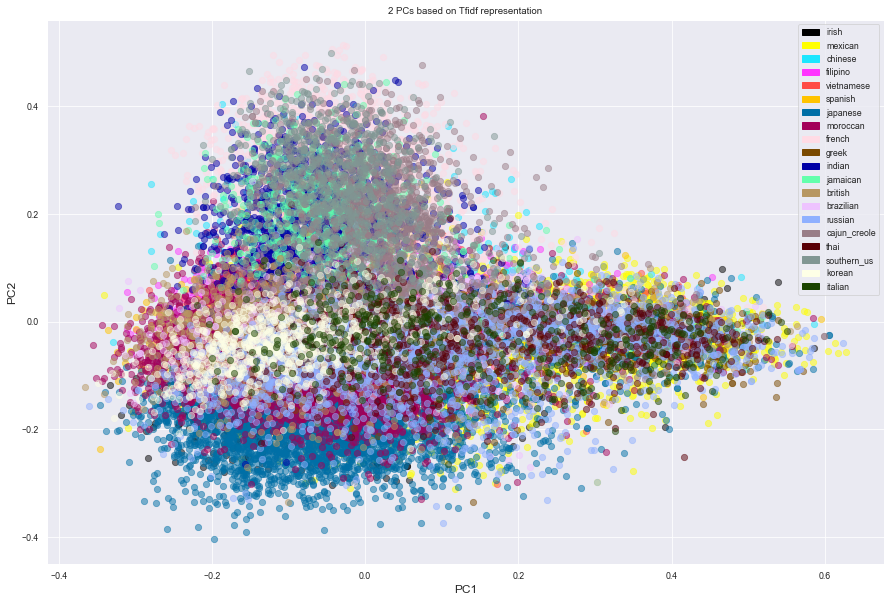

In [16]:
# Plot the PCA graph
plot2Components(result, "2 PCs based on Tfidf representation", "PC1", "PC2", data)

In [17]:
# Plot TSNE on the same result
tfidf_tsne = TSNE(n_components=2).fit_transform(tfidf)

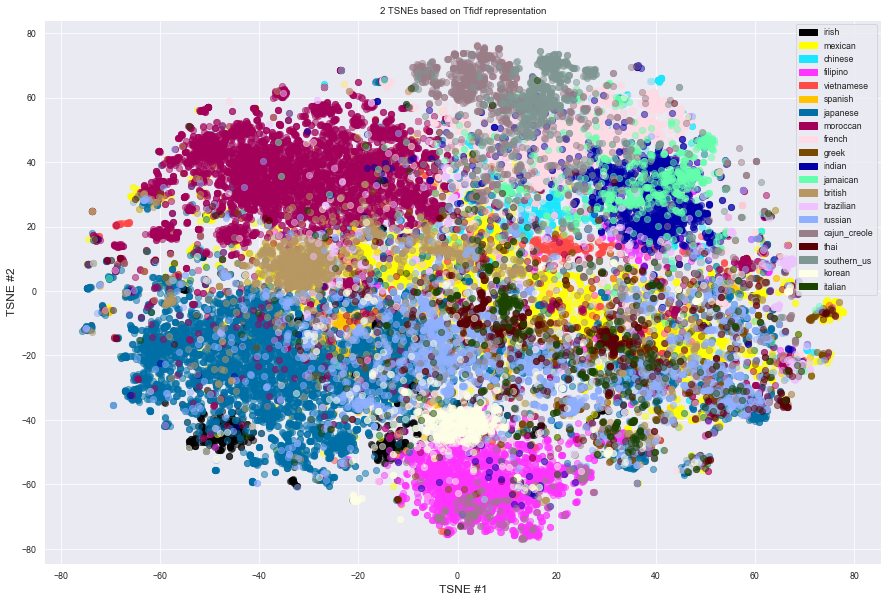

In [18]:
# Plot TSNE based on TFIDF representation
plot2Components(tfidf_tsne, "2 TSNEs based on Tfidf representation", "TSNE #1", "TSNE #2", data)

**PCA vs. TSNE on document-term matrix representation**

We see that document-term matrix doesn't provide a visualization better than tfidf representation in the PCA plot though they present similar pattern. The clusters overlap with each other more than we can see from the PCA plot based on tfidf representation. The TSNE based on document-term matrix representation presents a similar pattern as the one based on tfidf representation.

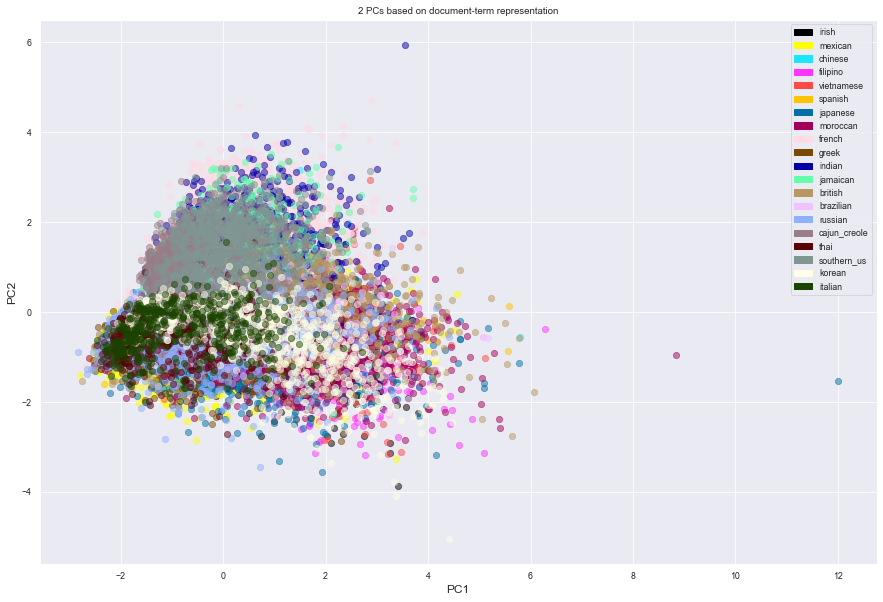

In [19]:
# Implement PCA on the standardized data
dtm_result = pca.fit_transform(dtm)
# Plot the PCA 
plot2Components(dtm_result, "2 PCs based on document-term representation", "PC1", "PC2", data)

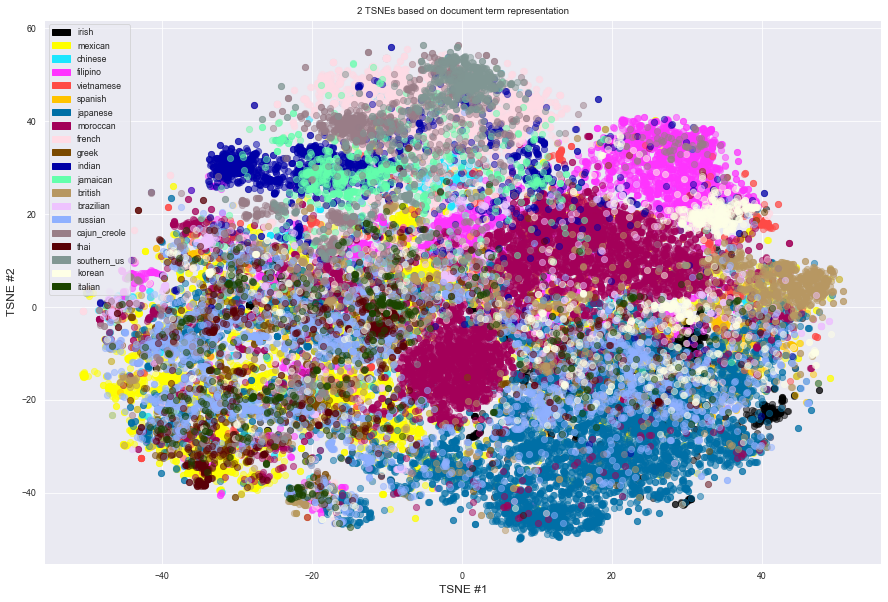

In [19]:
# Plot TSNE on the same result
dtm_tsne = TSNE(n_components=2).fit_transform(dtm)
plot2Components(dtm_tsne, "2 TSNEs based on document term representation", "TSNE #1", "TSNE #2", data)

**PCA vs. TSNE on normalized document-term matrix representation**

Below, we can see that PCA is sensitive to the data being normalized as the clusters are now more sparse, whereas TSNE behaves very similarly as the one without normalization.

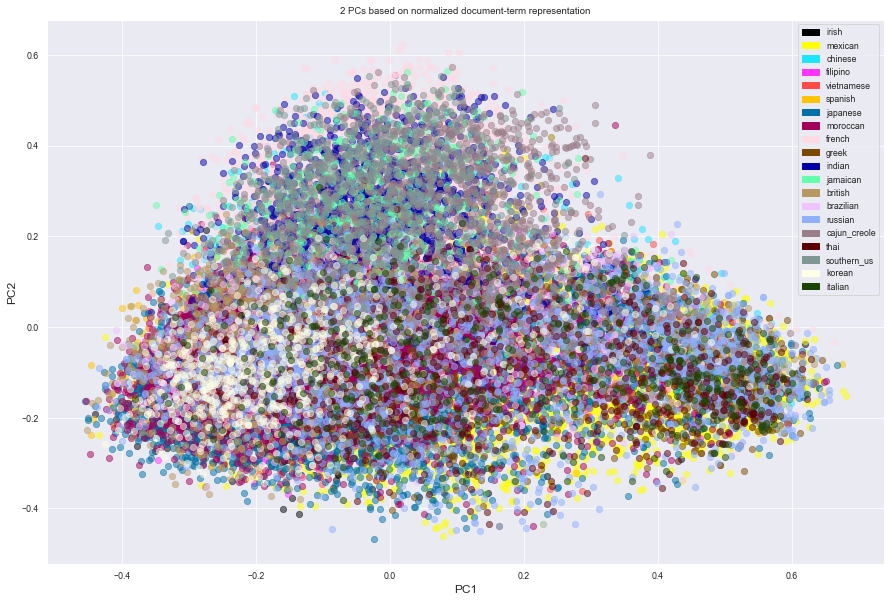

In [21]:
# Implement PCA on the standardized data
norm_dtm_result = pca.fit_transform(norm_dtm)
# Plot the PCA for normalized document-term matrices
plot2Components(norm_dtm_result, "2 PCs based on normalized document-term representation", "PC1", "PC2", data)

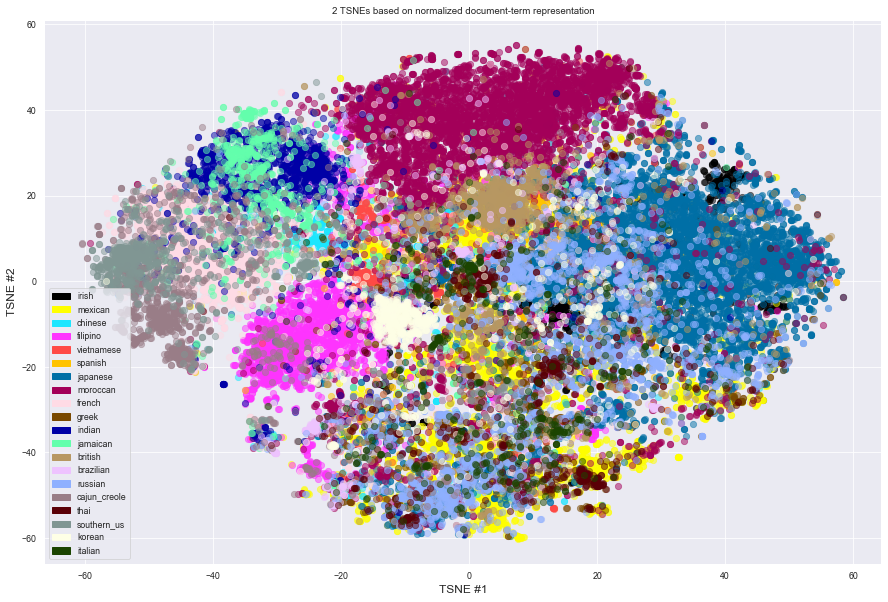

In [22]:
# Plot TSNE on the same result
norm_dtm_tsne = TSNE(n_components=2).fit_transform(norm_dtm)
plot2Components(norm_dtm_tsne, "2 TSNEs based on normalized document-term representation", "TSNE #1", "TSNE #2", data)

**PCA vs. TSNE on word2vec representation**

We see that both PCA and TSNE based on word2vec representation present more distinct and separable clusters, especially for TSNE. For example, in TSNE, we can clearly see a standlone cluster for the Moroccan food, however, the Italian food cluster are very sparse at the same time in the TSNE.

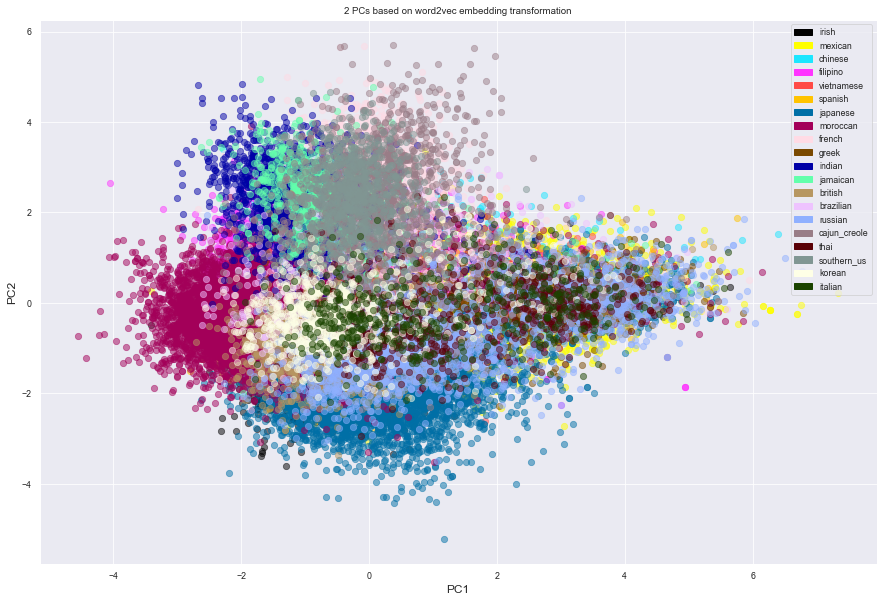

In [30]:
# Implement PCA on numerical signal transformed from word2vec model 
word2vec_result = pca.fit_transform(avg_word_mat)
plot2Components(word2vec_result, "2 PCs based on word2vec embedding transformation", "PC1", "PC2", data)

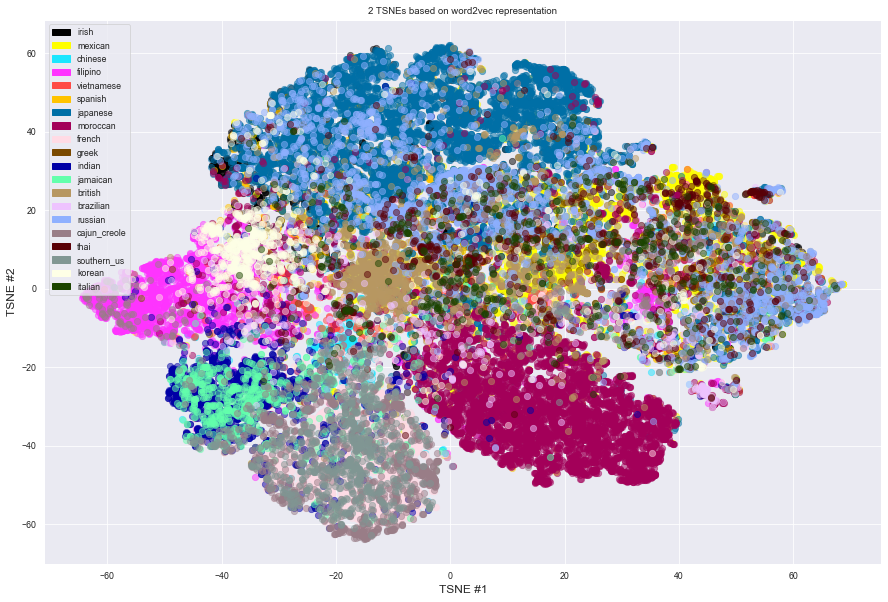

In [46]:
# Plot TSNE on the word2vec representation
word2vec_tsne = TSNE(n_components=2).fit_transform(avg_word_mat)
plot2Components(word2vec_tsne, "2 TSNEs based on word2vec representation", "TSNE #1", "TSNE #2", data)

**PCA vs. TSNE on normalized word2vec representation**


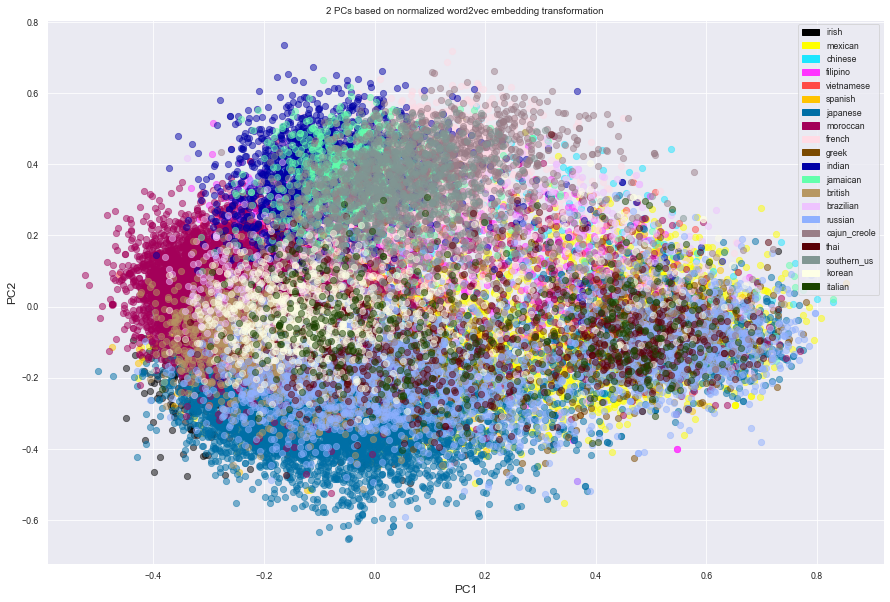

In [32]:
# Implement PCA on the numerical signal transformed from normalized word2vec model 
norm_word2vec_result = pca.fit_transform(norm_avg_word_mat)
plot2Components(norm_word2vec_result, "2 PCs based on normalized word2vec embedding transformation", "PC1", "PC2", data)

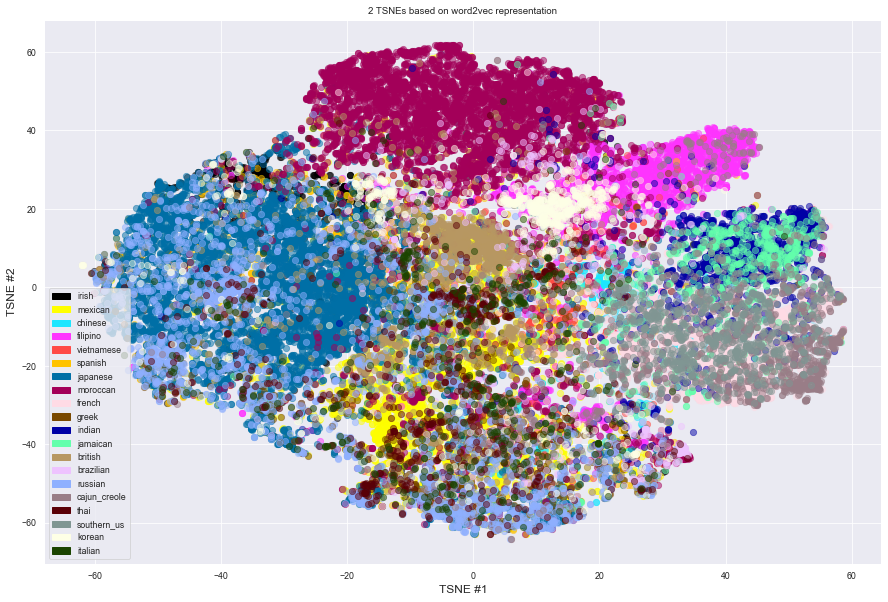

In [47]:
# Plot TSNE on the normalized word2vec 
norm_word2vec_tsne = TSNE(n_components=2).fit_transform(norm_avg_word_mat)
plot2Components(norm_word2vec_tsne, "2 TSNEs based on word2vec representation", "TSNE #1", "TSNE #2", data)

**K Means Clustering for mapping labels**

**Comments:**

From the three confusion matricies below. We see that K-Means perform pretty well on recovering the clusters especially for Chinese, Indian, Thai, etc. from Tfidf representation, whereas based on document-term matrix, K-Means seems to provide more spare clusters i.e. spreading across multiple clusters for each label in general. It shows similar patterns as indicated previously by the PCA plots above, where the document-term matrix presented in PCA plot mostly overlap and the clusters in the PCA plot based on the tfidf representation appear to be less overlapping. For the word2vec representation, K-Means also performs result similar to what we see from the confusion matrix based on document-term representation.

In [17]:
# Apply K-means clustering for tfidf
kmeans = KMeans(n_clusters=20, random_state=seed).fit(tfidf)
kmeans.labels_

array([10, 12,  9, ..., 15,  2,  8], dtype=int32)

In [18]:
# Instantiate the encoder class
le = LabelEncoder()
# Get the encoded labels for each task
y = le.fit_transform(data['cuisine'])
# Show which task each label corresponds to
le.inverse_transform(np.arange(20))

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

**Confusion matrix based on Tfidf representation**

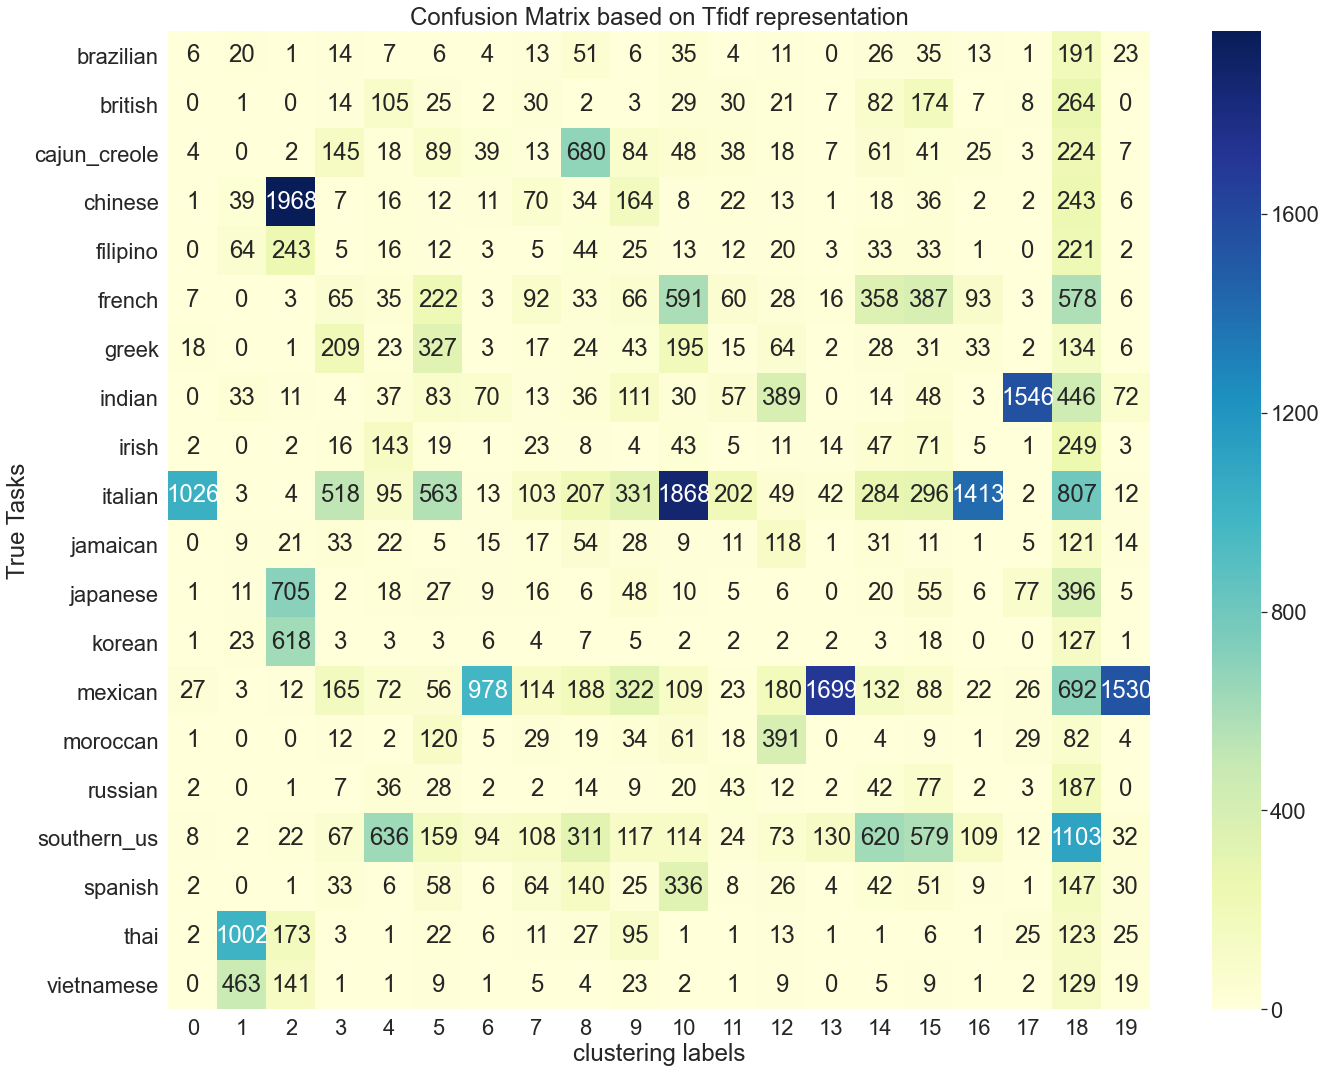

In [29]:
# creating a confusion matrix 
cm = confusion_matrix(y, kmeans.labels_, labels=np.arange(20))
# plot confusion matrix
plotCM(cm, le,cm_title='Confusion Matrix based on Tfidf representation')

**Confusion matrix based on document-term matrix**

In [31]:
# Apply K-means clustering for dtm
kmeans_dtm = KMeans(n_clusters=20, random_state=seed).fit(dtm)
# creating a confusion matrix 
cm_dtm = confusion_matrix(y, kmeans_dtm.labels_, labels=np.arange(20))

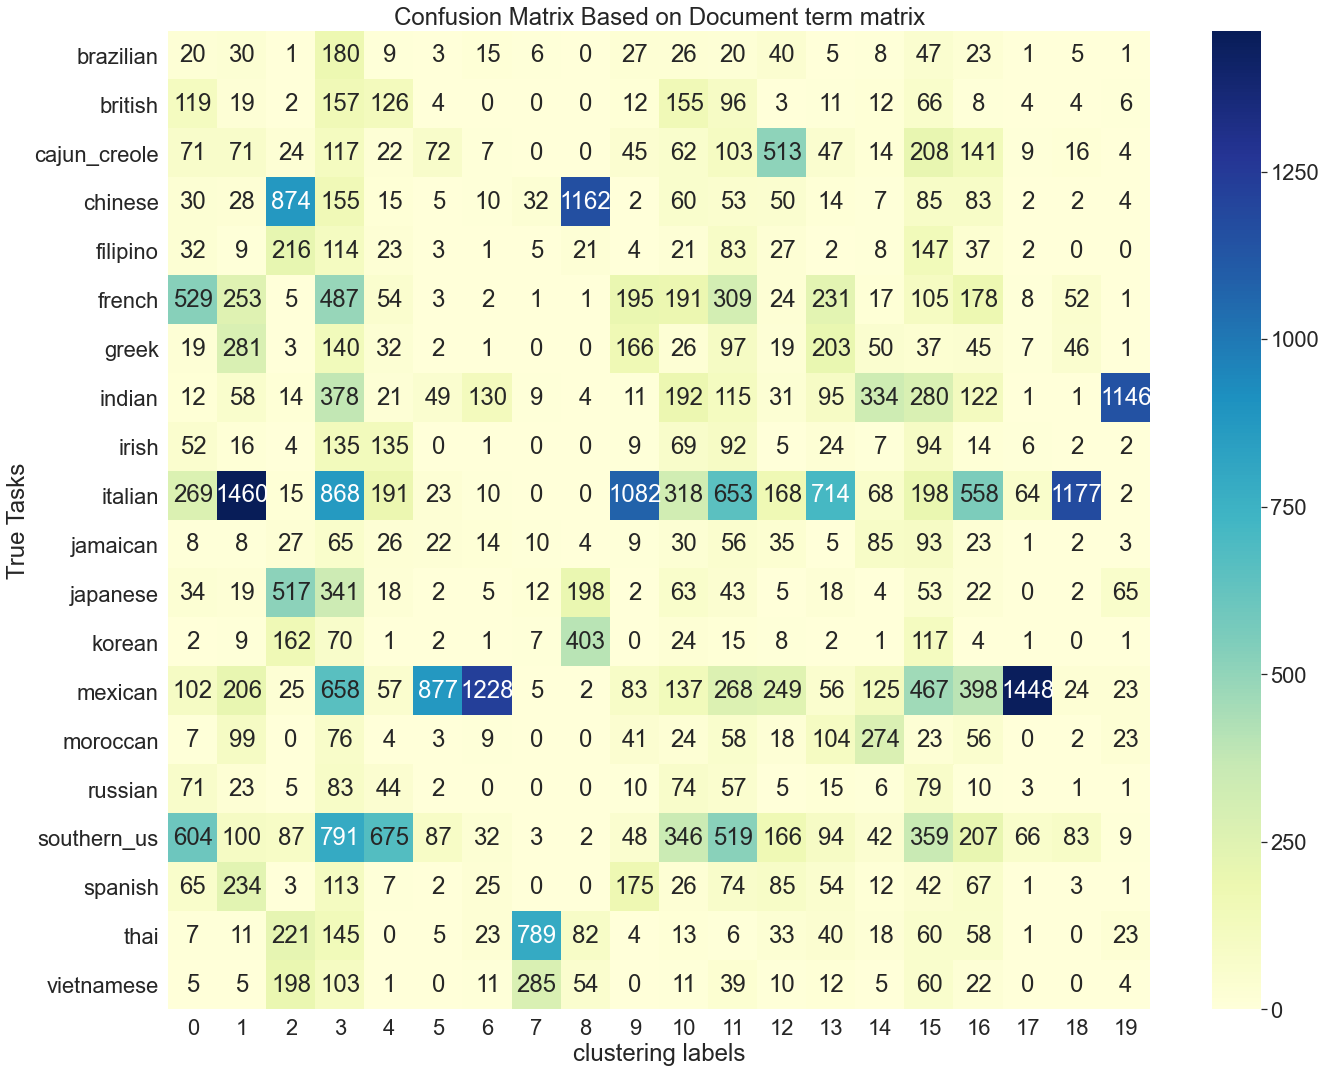

In [32]:
# plot confusion matrix
plotCM(cm_dtm, le,'Confusion Matrix Based on Document term matrix')

**Confusion matrix based on word2vec representation**

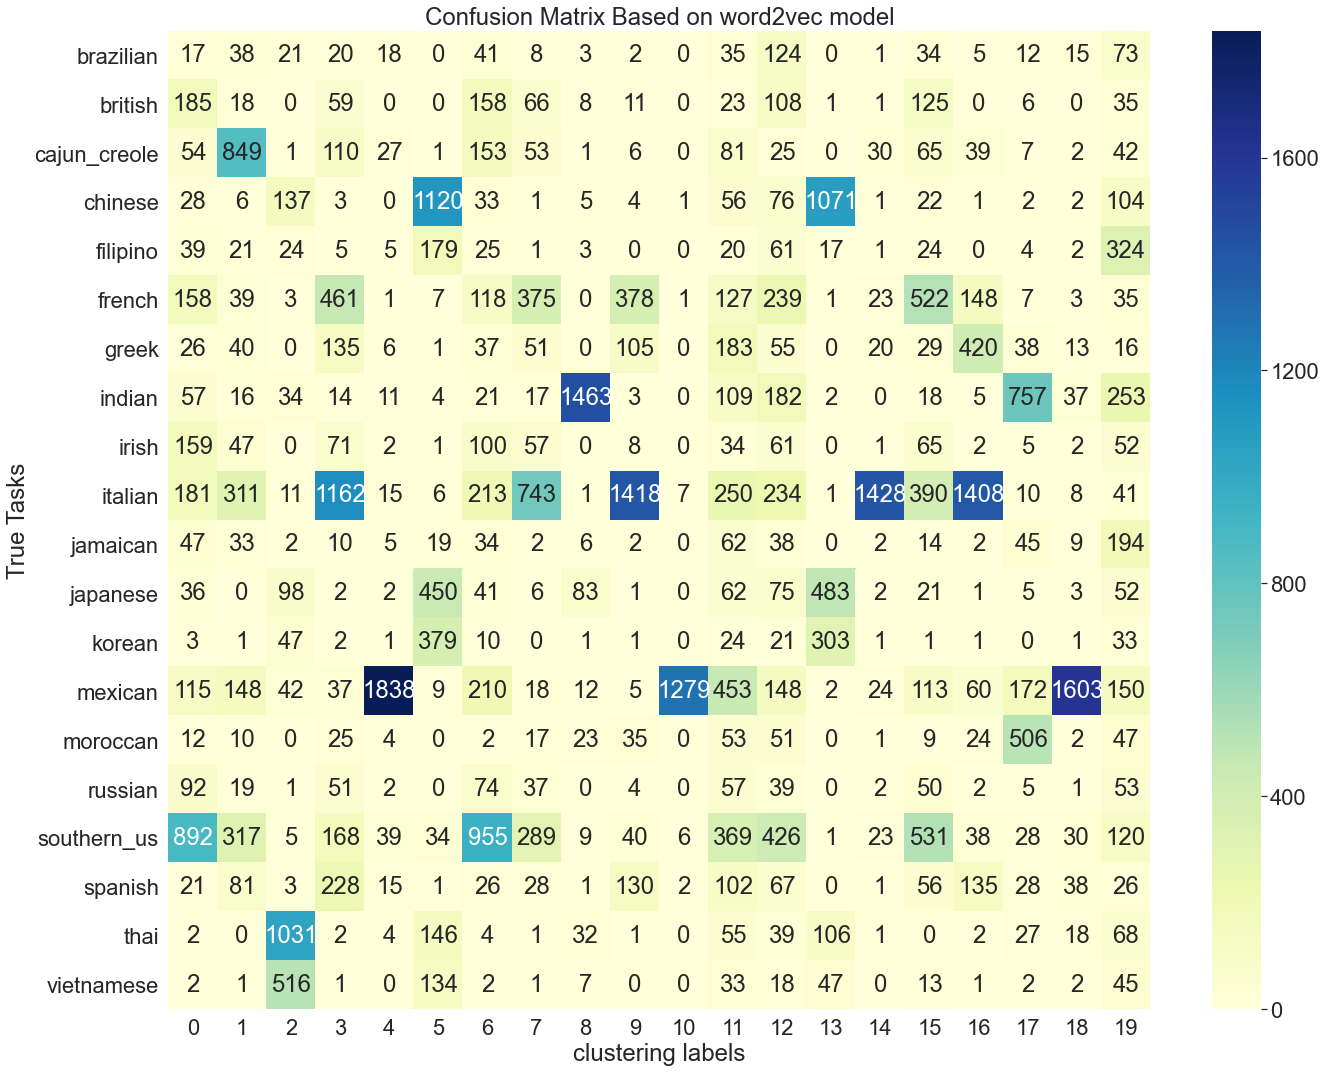

In [33]:
# Apply K-means clustering for word2vec representation
kmeans_avg_word_mat = KMeans(n_clusters=20, random_state=seed).fit(avg_word_mat)
# creating a confusion matrix 
cm_avg_word_mat = confusion_matrix(y, kmeans_avg_word_mat.labels_, labels=np.arange(20))
# plot confusion matrix
plotCM(cm_avg_word_mat, le,'Confusion Matrix Based on word2vec model')

**Train and Test split**

In [32]:
# Randomly split the training and testing data
# Tfidf representation
tf_X_train, tf_X_test, tf_y_train, tf_y_test = train_test_split(tfidf, y, test_size = 0.3, random_state = seed, stratify= y)
# Doc-term representation
dtm_X_train, dtm_X_test, dtm_y_train, dtm_y_test = train_test_split(dtm, y, test_size = 0.3, random_state = seed, stratify= y)
# Normalized doc-term representation
norm_dtm_X_train, norm_dtm_X_test, norm_dtm_y_train, norm_dtm_y_test = train_test_split(norm_dtm, y, test_size = 0.3, random_state = seed, stratify= y)
# 300 features numeric signals based on word2vec model
word2vec_X_train, word2vec_X_test, word2vec_y_train, word2vec_y_test = train_test_split(avg_word_mat, y, test_size = 0.3, random_state = seed, stratify= y)
# 300 features numeric signals based on normalized word2vec model
norm_word2vec_X_train, norm_word2vec_X_test, norm_word2vec_y_train, norm_word2vec_y_test = train_test_split(norm_avg_word_mat, y, test_size = 0.3, random_state = seed, stratify= y)

**Model comparison**

We will select a suite of different algorithms capable of working on this classification
problem. The algorithms selected include:

* Linear algorithms: Logistic Regression (LR) and Linear Discriminant Analysis (LDA).

* Non-linear algorithms: Classification and Regression Trees (CART), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

* Bagging methods: Random Forest (RF)

* Boosting methods: AdaBoost (Ada)

* Multilayer perceptron: feedforward neural networks(FNN)

We didn't include support vector machine and gradient boosting classifier because of the excessive amount of runtime they took to deliver results.

**Evaluation metric**

We use F1-micro score as our evaluation metric as we are dealing with imbalanced dataset in a multiclass classification setting, we are only interested in simply maximizing the number of correct predictions the classifier makes. 

**Preliminary result**

We summarize some results based on 5-fold cross validation and f1-micro score for each of the models with respect to each of the vectorial representations.

| Model| Tf-idf matrix 	| Document-term matrix 	| Normalized document-term matrix| Word2vec 	| Normalized word2vec 	| Parameters used|
|----------------- |:-------:	|:----------:	|:-----------------------------------------------:	|:-------:	|:-------:	|:-------:	|
| LR   	|**0.769444**  	|  **0.778457**	|0.747930 	| 0.623149 	| 0.596318 	| solver='liblinear', multi_class='ovr'|
| LDA   |     0.748324  	|  0.735644 | 0.693047 	| **0.683024** 	| **0.664882** 	| default |
| KNN   |     0.724365   	|  0.625842 | 0.693047  |0.608242 	| 0.615925 	| default|
| CART  |   0.607913     	|  0.632126 | 0.609823  |0.514744   | 0.522680 	| default|
| NB    |   0.273512     	|  0.273371 | 0.279045  |0.485507   | 0.497465  | default|
| RF    |  0.684781      	|  0.695374 | 0.677740  |0.611798 	| 0.619765 	| default|
| Ada   |   0.526056     	|  0.545986	| 0.519485  |0.474161	| 0.482623	| default|
| NN|0.758162  	|  0.760497	|**0.758450** 	| 0.636076 	| 0.640458 	|{'activation1': 'relu', 'activation2': 'relu', 'bn': False, 'hidden_layers': 2, 'init': 'he_uniform', 'n_features': 2849, 'node_num': 30, 'optimizer': 'adam'}**with DTM Matrix**|

**Observations:**

* We see that logistic regression consistently obtain the highest f1-micro score in the representation based on bag-of-words model. 
* KNN usually performs better on normalized data setting. 
* Interestingly, naive bayes has the lowest score for both tfidf and document-term matricies. One potential reason can be due to the feature independence assumption behind naive bayes, which is not the case for the data we provide. 
* We also see that Random Forest consistently perform better than the decision tree classifier. This is typical becasue RF consists of multiple single trees each based on a random sample of the training data to provide more stable and accurate result.
* Overall, linear algorithms seem to work better than non-linear algorithms in this data set.

**Spot-check all selected classification algorithms**

In [40]:
# List all the models
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('AB', AdaBoostClassifier(random_state=seed)))

LR: 0.769444 (0.002926)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.748324 (0.003771)
KNN: 0.724365 (0.002544)
CART: 0.607913 (0.005307)
NB: 0.273512 (0.005575)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

RF: 0.684781 (0.001800)
AB: 0.526056 (0.014432)


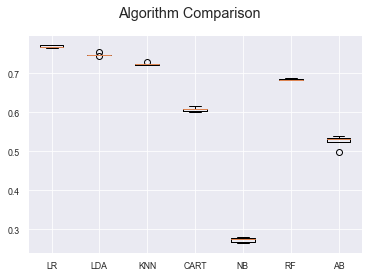

In [42]:
spotcheck(tf_X_train, tf_y_train, models, foldnum=5 , scoring="f1_micro", random_state=seed)

LR: 0.778457 (0.002384)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.735644 (0.002490)
KNN: 0.625842 (0.004791)
CART: 0.632126 (0.003105)
NB: 0.273371 (0.006092)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

RF: 0.695374 (0.005213)
AB: 0.545986 (0.012179)


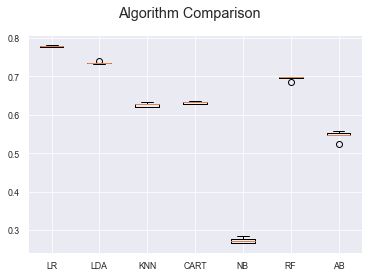

In [43]:
spotcheck(dtm_X_train, dtm_y_train, models, foldnum=5 , scoring="f1_micro", random_state=seed)

LR: 0.746959 (0.002399)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.747930 (0.004629)
KNN: 0.693047 (0.004368)
CART: 0.609823 (0.003807)
NB: 0.279045 (0.003606)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

RF: 0.677740 (0.002347)
AB: 0.519485 (0.016300)


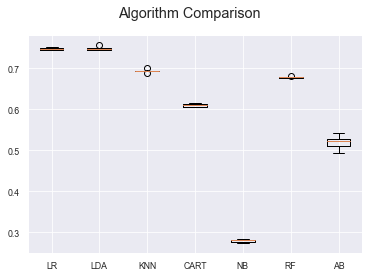

In [44]:
spotcheck(norm_dtm_X_train, norm_dtm_y_train, models, foldnum=5 , scoring="f1_micro", random_state=seed)

LR: 0.623149 (0.002991)
LDA: 0.683024 (0.003426)
KNN: 0.608242 (0.002057)
CART: 0.514744 (0.005394)
NB: 0.485507 (0.004021)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

RF: 0.611798 (0.003154)
AB: 0.474161 (0.006207)


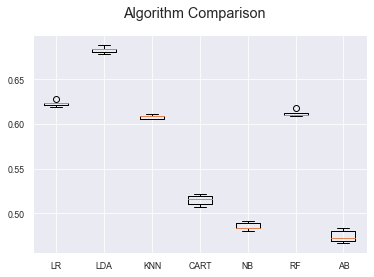

In [45]:
spotcheck(word2vec_X_train, word2vec_y_train, models, foldnum=5 , scoring="f1_micro", random_state=seed)

LR: 0.596318 (0.002592)
LDA: 0.664882 (0.002024)
KNN: 0.615925 (0.003745)
CART: 0.522680 (0.005495)
NB: 0.497465 (0.007618)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

RF: 0.619765 (0.004550)
AB: 0.482623 (0.015601)


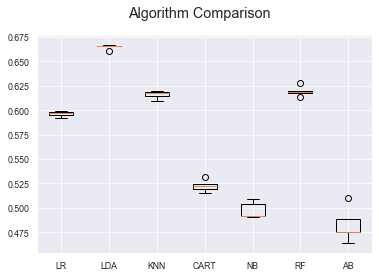

In [46]:
spotcheck(norm_word2vec_X_train, norm_word2vec_y_train, models, foldnum=5 , scoring="f1_micro", random_state=seed)

**Improve results with tuning**

We investigate tuning the parameters for three algorithms that show promise from the spot-checking in the previous section: logistic regression, LDA and KNN. We will use the data set with which the algorithm performs the best. However, the performance of logistic regression doesn't improve. KNN has gone from 0.724365 to 0.737905 with an increased number of neighbours used. LDA also doesn't have improvement. 

In [17]:
# Fine-tune logistic regression model
model = LogisticRegression(multi_class='ovr')
C = [0.0001, 0.001, 0.1, 1, 10, 20] 
solver = ["lbfgs", "liblinear"]
grid = dict(C=C, solver=solver)
lr_result = tune(dtm_X_train, dtm_y_train, model=model, grid=grid, num_fold=5, scoring="f1_micro", random_state=seed)

Best: 0.778456 using {'C': 1, 'solver': 'liblinear'}


In [21]:
# Fine-tune KNN classifier
model = KNeighborsClassifier()
n_neighbors = [3,5,7,10,15]
grid = dict(n_neighbors=n_neighbors)
lr_result = tune(tf_X_train, tf_y_train, model=model, grid=grid, num_fold=5, scoring="f1_micro", random_state=seed)

Best: 0.737905 using {'n_neighbors': 15}


In [19]:
# Fine-tune LDA classifier
model = LinearDiscriminantAnalysis()
shrinkage = ["auto", None]
grid = dict(shrinkage = shrinkage)
lda_result = tune(tf_X_train, tf_y_train, model=model, grid=grid, num_fold=5, scoring="f1_micro", random_state=seed)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Best: 0.748321 using {'shrinkage': None}


**Feedforward neural networks with Adam optimizers**

In [14]:
# create model by using a keras wrapper
import time # to estimate running time

model = KerasClassifier(build_fn=build_model,epochs =10, batch_size=128, verbose=0)
# define the grid search parameters
activation = ['softmax', 'relu', 'sigmoid']
additional_hidden_layers = [2,3] 
node_num = [20,30]
optimizer = ['adam'] # define optimizer
init = ['he_uniform','normal'] # Initializers define the way to set the initial random weights
bn = [True, False]# Whether we should add batch normalization layer

In [14]:
# Get the number of features for TFIDF 
t1 = time.time()
features = [tf_X_train.shape[1]]
# Specify the grid
param_grid = dict(node_num=node_num, bn=bn, hidden_layers=additional_hidden_layers, activation1=activation, activation2=['relu'], optimizer = optimizer, init=init, n_features=features)
tfidf_nn_result = tune(tf_X_train, tf_y_train, model, grid=param_grid, num_fold=5, scoring='f1_micro', random_state = seed)
t2 = time.time()
print(t2-t1)
del tfidf_nn_result,features,param_grid
gc.collect()

Best: 0.758162 using {'activation1': 'relu', 'activation2': 'relu', 'bn': False, 'hidden_layers': 2, 'init': 'he_uniform', 'n_features': 2849, 'node_num': 30, 'optimizer': 'adam'}
1936.9890015125275


4712

In [18]:
# Get the number of features for dtm
t1 = time.time()
features = [dtm_X_train.shape[1]]
# Specify the grid
param_grid = dict(node_num=node_num, bn=bn, hidden_layers=additional_hidden_layers, activation1=activation, activation2=['relu'], optimizer = optimizer, init=init, n_features=features)
dtm_nn_result = tune(dtm_X_train, dtm_y_train, model, grid=param_grid, num_fold=5, scoring='f1_micro', random_state = seed)
t2 = time.time()
print(t2-t1)
del dtm_nn_result,features,param_grid # remove variables to release some memory 
gc.collect() # clear

Best: 0.760497 using {'activation1': 'relu', 'activation2': 'relu', 'bn': False, 'hidden_layers': 2, 'init': 'he_uniform', 'n_features': 2849, 'node_num': 30, 'optimizer': 'adam'}
1989.2538795471191


4694

In [24]:
t1 = time.time()
features = [norm_dtm_X_train.shape[1]]
# Specify the grid
param_grid = dict(node_num=node_num, bn=bn, hidden_layers=additional_hidden_layers, activation1=activation, activation2=['relu'], optimizer = optimizer, init=init, n_features=features)
norm_dtm_nn_result = tune(norm_dtm_X_train, norm_dtm_y_train, model, grid=param_grid, num_fold=5, scoring='f1_micro', random_state = seed)
t2 = time.time()

Best: 0.758450 using {'activation1': 'relu', 'activation2': 'relu', 'bn': False, 'hidden_layers': 2, 'init': 'he_uniform', 'n_features': 2849, 'node_num': 30, 'optimizer': 'adam'}


In [27]:
print(t2-t1)
del norm_dtm_nn_result,features,param_grid # remove variables to release some memory 
gc.collect() # clear

1846.2670440673828


28

In [15]:
t1 = time.time()
features = [word2vec_X_train.shape[1]]
# Specify the grid
param_grid = dict(node_num=node_num, bn=bn, hidden_layers=additional_hidden_layers, activation1=activation, activation2=['relu'], optimizer = optimizer, init=init, n_features=features)
norm_dtm_nn_result = tune(word2vec_X_train, word2vec_y_train, model, grid=param_grid, num_fold=5, scoring='f1_micro', random_state = seed)
t2 = time.time()

Best: 0.636076 using {'activation1': 'sigmoid', 'activation2': 'relu', 'bn': True, 'hidden_layers': 2, 'init': 'he_uniform', 'n_features': 300, 'node_num': 30, 'optimizer': 'adam'}


In [16]:
print(t2-t1)
del norm_dtm_nn_result,features,param_grid # remove variables to release some memory 
gc.collect() #Clear

320.9309878349304


9059

In [17]:
t1 = time.time()
features = [norm_word2vec_X_train.shape[1]]
# Specify the grid
param_grid = dict(node_num=node_num, bn=bn, hidden_layers=additional_hidden_layers, activation1=activation, activation2=['relu'], optimizer = optimizer, init=init, n_features=features)
norm_dtm_nn_result = tune(norm_word2vec_X_train, norm_word2vec_y_train, model, grid=param_grid, num_fold=5, scoring='f1_micro', random_state = seed)
t2 = time.time()

Best: 0.640458 using {'activation1': 'sigmoid', 'activation2': 'relu', 'bn': True, 'hidden_layers': 3, 'init': 'he_uniform', 'n_features': 300, 'node_num': 30, 'optimizer': 'adam'}


In [18]:
print(t2-t1)
del norm_dtm_nn_result,features,param_grid # remove variables to release some memory 
gc.collect()

304.1402201652527


11187

**Predict on the test set and plot the F1-micro score curve**

LR - dtm Matrix

In [44]:
# Binarize the class for plotting
Y = label_binarize(y, classes=np.arange(20))
# Get the same set of training set correponding to each class based on the same seed
_dtm_X_train, _dtm_X_test, dtm_Y_train, dtm_Y_test = train_test_split(dtm, Y, test_size = 0.3, random_state = seed, stratify= y)

Average precision score, micro-averaged over all classes: 0.84


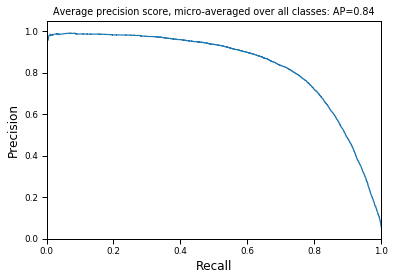

In [203]:
lr1 = OneVsRestClassifier(LogisticRegression(C=1, solver="liblinear", multi_class='ovr'),n_jobs = 6)
lr1.fit(_dtm_X_train, dtm_Y_train)
y_score1 = lr1.predict_proba(_dtm_X_test) # uses desicion function
plotF1(y_score1, dtm_Y_test)

LDA - tf matrix

In [54]:
# Get the same set of training set correponding to each class based on the same seed
_tf_X_train, _tf_X_test, tf_Y_train, tf_Y_test = train_test_split(tfidf, Y, test_size = 0.3, random_state = seed, stratify= y)

In [23]:
# Define the model
lr2 = OneVsRestClassifier(LinearDiscriminantAnalysis(shrinkage = None),n_jobs = 6)
lr2.fit(_tf_X_train, tf_Y_train)

C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\57609\Anacond

Average precision score, micro-averaged over all classes: 0.75


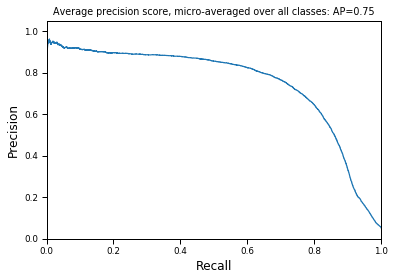

In [30]:
y_score2 = lr2.decision_function(_tf_X_test)
plotF1(y_score2, tf_Y_test)

KNN - tf matrix

In [195]:
# KNN model = tf, this chunk costs 20 minutes, using n_jobs will return serial error.
lr3 = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 15))
lr3.fit(_tf_X_train, tf_Y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=15))

Average precision score, micro-averaged over all classes: 0.79


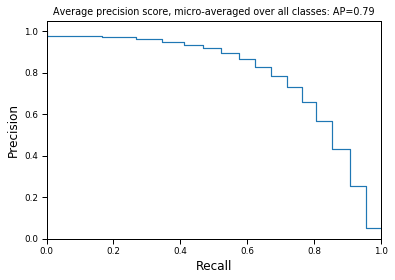

In [196]:
y_score3 = lr3.predict_proba(_tf_X_test) #takes 9~10 hours to run
plotF1(y_score3, tf_Y_test)

CART - dtm matrix

In [197]:
# Define the model
lr4 = OneVsRestClassifier(DecisionTreeClassifier(),n_jobs=-1)
lr4.fit(_dtm_X_train, dtm_Y_train)

Average precision score, micro-averaged over all classes: 0.45


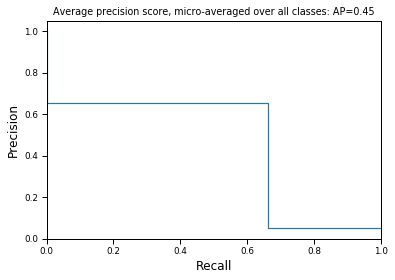

In [75]:
# Uses predicted probability 
y_score4 = lr4.predict_proba(_dtm_X_test)
plotF1(y_score4, dtm_Y_test)

NB - normalized-word2vec

In [198]:
_norm_word2vec_X_train, _norm_word2vec_X_test, norm_word2vec_Y_train, norm_word2vec_Y_test = train_test_split(norm_avg_word_mat, Y, test_size = 0.3, random_state = seed, stratify= y)

In [199]:
# Define the model
lr5 = OneVsRestClassifier(GaussianNB(),n_jobs=-1)
lr5.fit(_norm_word2vec_X_train, norm_word2vec_Y_train)

OneVsRestClassifier(estimator=GaussianNB(), n_jobs=-1)

Average precision score, micro-averaged over all classes: 0.22


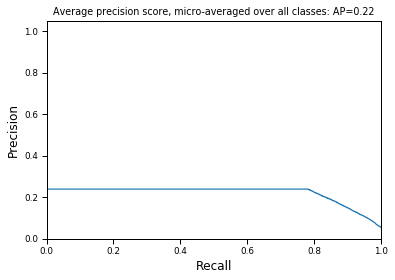

In [200]:
# use predicted probability
y_score5 = lr5.predict_proba(_norm_word2vec_X_test)
plotF1(y_score5, norm_word2vec_Y_test)

RF - dtm matrix

In [81]:
lr6 = OneVsRestClassifier(RandomForestClassifier(random_state=seed),n_jobs=-1)
lr6.fit(_dtm_X_train, dtm_Y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=208),
                    n_jobs=-1)

Average precision score, micro-averaged over all classes: 0.83


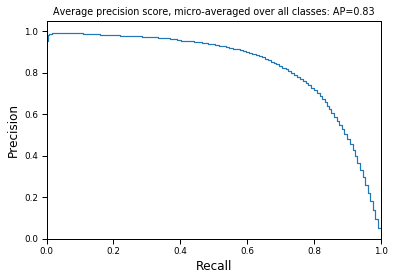

In [113]:
# use predicted probability
y_score6 = lr6.predict_proba(_dtm_X_test)
plotF1(y_score6, dtm_Y_test)

Adaboost - dtm matrix

In [117]:
lr7 = OneVsRestClassifier(AdaBoostClassifier(random_state=seed),n_jobs=-1)
lr7.fit(_dtm_X_train, dtm_Y_train)

OneVsRestClassifier(estimator=AdaBoostClassifier(random_state=208), n_jobs=-1)

Average precision score, micro-averaged over all classes: 0.76


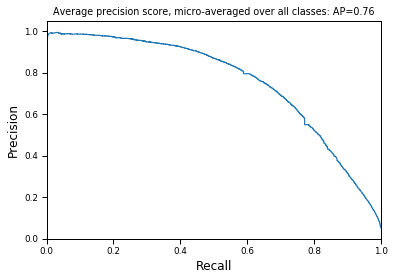

In [118]:
# uses decision function to plot
y_score7 = lr7.decision_function(_dtm_X_test)
plotF1(y_score7, dtm_Y_test)

NN - dtm matrix

In [171]:
nnmodel = build_model(node_num = 30, bn=False, activation1 = 'relu', activation2 = 'relu', hidden_layers = 2, optimizer = 'adam', init = 'he_uniform', n_features = 2849)

In [194]:
nnmodel.fit(_dtm_X_train,dtm_y_train,epochs=20,batch_size = 128,verbose = 1) # slightly increases epoch

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2419
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2339
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2272
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2180
Epoch 5/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2098
Epoch 6/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2031
Epoch 7/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1978
Epoch 8/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1919
Epoch 9/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1853
Epoch 10/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1796
Epoch 11/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1727
Epoch 12/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1689
Epoch 13/20
218/218 [====

In [187]:
y_score8 = nnmodel.predict_proba(_dtm_X_test) # Uses predicted probability

Average precision score, micro-averaged over all classes: 0.85


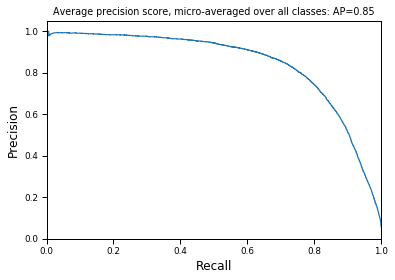

In [188]:
plotF1(y_score8, dtm_Y_test)